In [2]:
import scipy as sp
import scipy.linalg as spla
import scipy.optimize as spopt
import scipy.stats as spst
from sklearn.linear_model import LogisticRegressionCV


import numpy as np
import numpy.linalg as npla

import statsmodels as sm
import statsmodels.api as sma
smfOLS = sma.regression.linear_model.OLS.from_formula
smfLGT = sm.discrete.discrete_model.Logit.from_formula
from statsmodels.graphics.mosaicplot import mosaic

import seaborn as sns
sns.set(style='darkgrid')
import pandas as pd

import matplotlib.pyplot as plt

from inspect import signature as sig
import pandas as pd

#model = smfLGT("threat_level ~ age + gender + race + signs_of_mental_illness + flee + body_camera", data=df)
#model.fit().summary()

# Part 1
# Preparing of the data:

In [3]:
df = pd.read_csv('shootings.csv', sep=',')
df['threat_level'].replace('attack', 1 , inplace=True)
df['threat_level'].replace('undetermined', 0, inplace=True)
df['threat_level'].replace('other', 0, inplace=True)
df['age'] = df['age'].round(0).astype(int)

In [4]:
Guns = ['Guns']
Cold = ['Sharp objects', 'Piercing objects']
Unarmed = ['Unarmed']
Other = ['Unknown', 'Other unusual objects', 'Blunt instruments', 'Vehicles', 'Multiple', 'Electrical devices', 'Explosives', 'Hand tools']

def rename_arms(row):
    if row['arms_category'] in Guns: 
        return 'Guns'
    if row['arms_category'] in Cold: 
        return 'Cold'
    if row['arms_category'] in Other: 
        return 'Other'
    if row['arms_category'] in Unarmed: 
        return 'Unarmed'
    
# info from: https://www.270towin.com/content/blue-and-red-states
Blue = ['CA', 'OR', 'WA', 'MN', 'IL', 'NY', 'VT', 'ME', 'MA', 'RI', 'CT', 'NJ', 'DE', 'MD', 'DC', 'HI']
Red = ['AK', 'MT', 'ID', 'WY', 'UT', 'NE', 'ND', 'ST', 'KS', 'OK', 'TX', 'MO', 'AR', 'LA', 'MS', 'AL', 'TN',  'KY', 'WV', 'SC']
Swing = ['NV', 'AZ', 'NM', 'CO', 'IA', 'WI', 'MI', 'IN', 'OH', 'PA', 'NH', 'VA', 'NC', 'GA', 'FL']
def rename_states(row):
    if row['state'] in Blue: 
        return 'Blue'
    if row['state'] in Red: 
        return 'Red'
    if row['state'] in Swing: 
        return 'Swing'

In [5]:
df['a_type'] = df.apply(lambda x: rename_arms(x), axis = 1)
df['s_type'] = df.apply(lambda x: rename_states(x), axis = 1)

In [6]:
df['s_type'].value_counts()

Swing    1827
Red      1627
Blue     1427
Name: s_type, dtype: int64

In [7]:
df = df.drop(['manner_of_death', 'flee'], axis=1)

In [8]:
X = df.copy()
del X['name'],X['age'], X['date'], X['id'], X['arms_category'], X['state'], X['city'], X['armed']#, X['manner_of_death']
X = X.dropna()
y = X['threat_level']
X = X.drop(['threat_level'], axis=1)
X.head()

,gender,race,signs_of_mental_illness,body_camera,a_type,s_type
0,M,Asian,True,False,Guns,Blue
1,M,White,False,False,Guns,Blue
2,M,Hispanic,False,False,Unarmed,Red
3,M,White,True,False,Other,Blue
4,M,Hispanic,False,False,Cold,Swing


# Part 2 

# Descriptive analysis of the data

### Let's firstly overview the dataset

In [9]:
df.head(5)

,id,name,date,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,body_camera,arms_category,a_type,s_type
0,3,Tim Elliot,2015-01-02,gun,53,M,Asian,Shelton,WA,True,1,False,Guns,Guns,Blue
1,4,Lewis Lee Lembke,2015-01-02,gun,47,M,White,Aloha,OR,False,1,False,Guns,Guns,Blue
2,5,John Paul Quintero,2015-01-03,unarmed,23,M,Hispanic,Wichita,KS,False,0,False,Unarmed,Unarmed,Red
3,8,Matthew Hoffman,2015-01-04,toy weapon,32,M,White,San Francisco,CA,True,1,False,Other unusual objects,Other,Blue
4,9,Michael Rodriguez,2015-01-04,nail gun,39,M,Hispanic,Evans,CO,False,1,False,Piercing objects,Cold,Swing


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4895 entries, 0 to 4894
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       4895 non-null   int64 
 1   name                     4895 non-null   object
 2   date                     4895 non-null   object
 3   armed                    4895 non-null   object
 4   age                      4895 non-null   int64 
 5   gender                   4895 non-null   object
 6   race                     4895 non-null   object
 7   city                     4895 non-null   object
 8   state                    4895 non-null   object
 9   signs_of_mental_illness  4895 non-null   bool  
 10  threat_level             4895 non-null   int64 
 11  body_camera              4895 non-null   bool  
 12  arms_category            4895 non-null   object
 13  a_type                   4895 non-null   object
 14  s_type                   4881 non-null  

### The dataset consists of 4896 observations. Each observation represents a suspect killed by a US police officer for the period from 2015 to 2020. 

### Most variables are categorical. This is information about the suspect (race, gender, his weapon, etc.) and general information about the incident (state, city, flee, threat level). There are also boolean variables - the presence of visible mental illness in the suspect and the presence of a chest camera in the policeman.

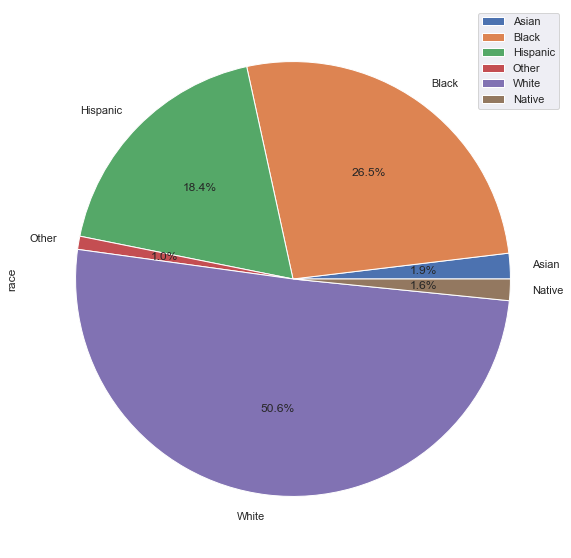

In [11]:
race_counts = df['race'].value_counts()
df_race_counts = pd.DataFrame({'race': race_counts}, 
                     index = ['Asian', 'Black', 'Hispanic', 'Other', 'White', 'Native']
                   )
df_race_counts.plot.pie(y='race', figsize=(10,10), autopct='%1.1f%%')

### As you can see, half of those killed by the police are white people. However, no conclusion can be drawn from this, because there are fewer people of color in America than the white population. There are also 26,5% of killed black suspects and 18,4% of killed hispanic people. Category other includes people of Middle East, for example.

Text(0.5, 1.0, 'Body camera')

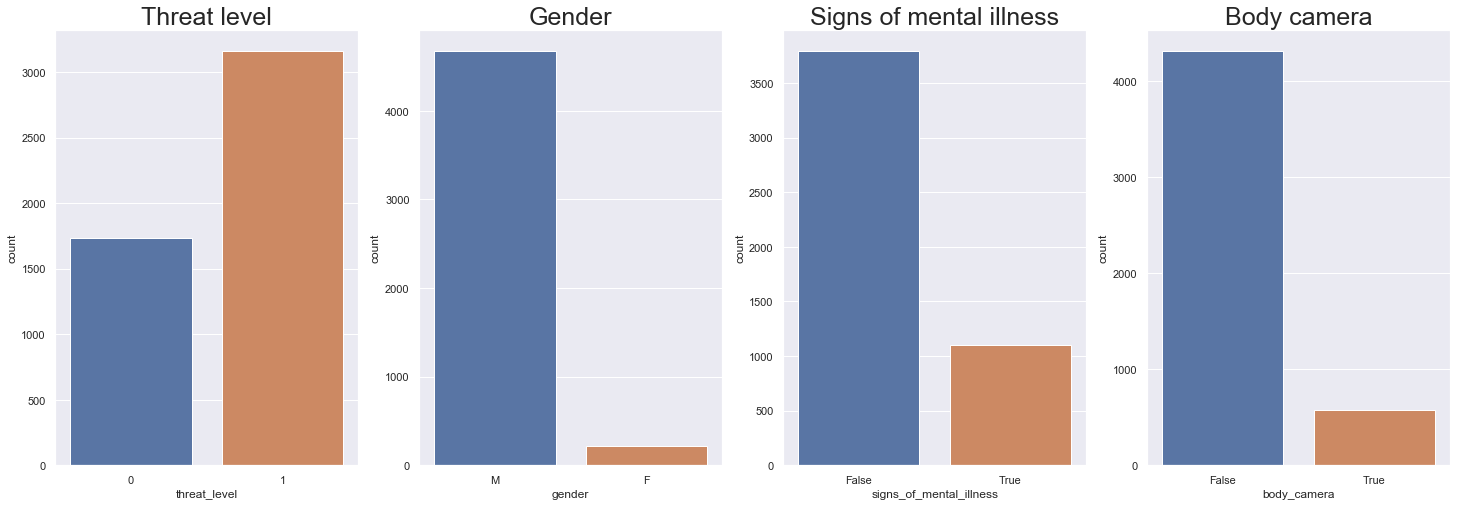

In [12]:
plt.figure(figsize=(25,8))
plt.subplot(1,4,1)
sns.countplot(x='threat_level', data=df)
plt.title('Threat level', fontsize=25)

plt.subplot(1,4,2)
sns.countplot(x='gender', data=df)
plt.title('Gender', fontsize=25)

plt.subplot(1,4,3)
sns.countplot(x='signs_of_mental_illness', data=df)
plt.title('Signs of mental illness', fontsize=25)

plt.subplot(1,4,4)
sns.countplot(x='body_camera', data=df)
plt.title('Body camera', fontsize=25)

#plt.figure(figsize=(20,10))
#ax = sns.countplot(x='threat_level', data=df)

### The threat level variable is of the greatest interest to us. The value 1 - implies an Attack, the officer in the investigation indicated the actions as an attack. If the value of this variable is 0, it means that the officer definitely did not evaluate the suspect's action as an attack. The suspect reached for his pocket, made a sharp movement, his hands were out of sight of the officer - all these actions are characterized as not an attack

### Other variables have a fairly obvious distribution. Most of those killed are males who wasn't fleeing. Most of the people had no visible mental disorders and at the same time only one in eight police officers had a body camera.

Text(0.5, 1.0, 'State dominant party')

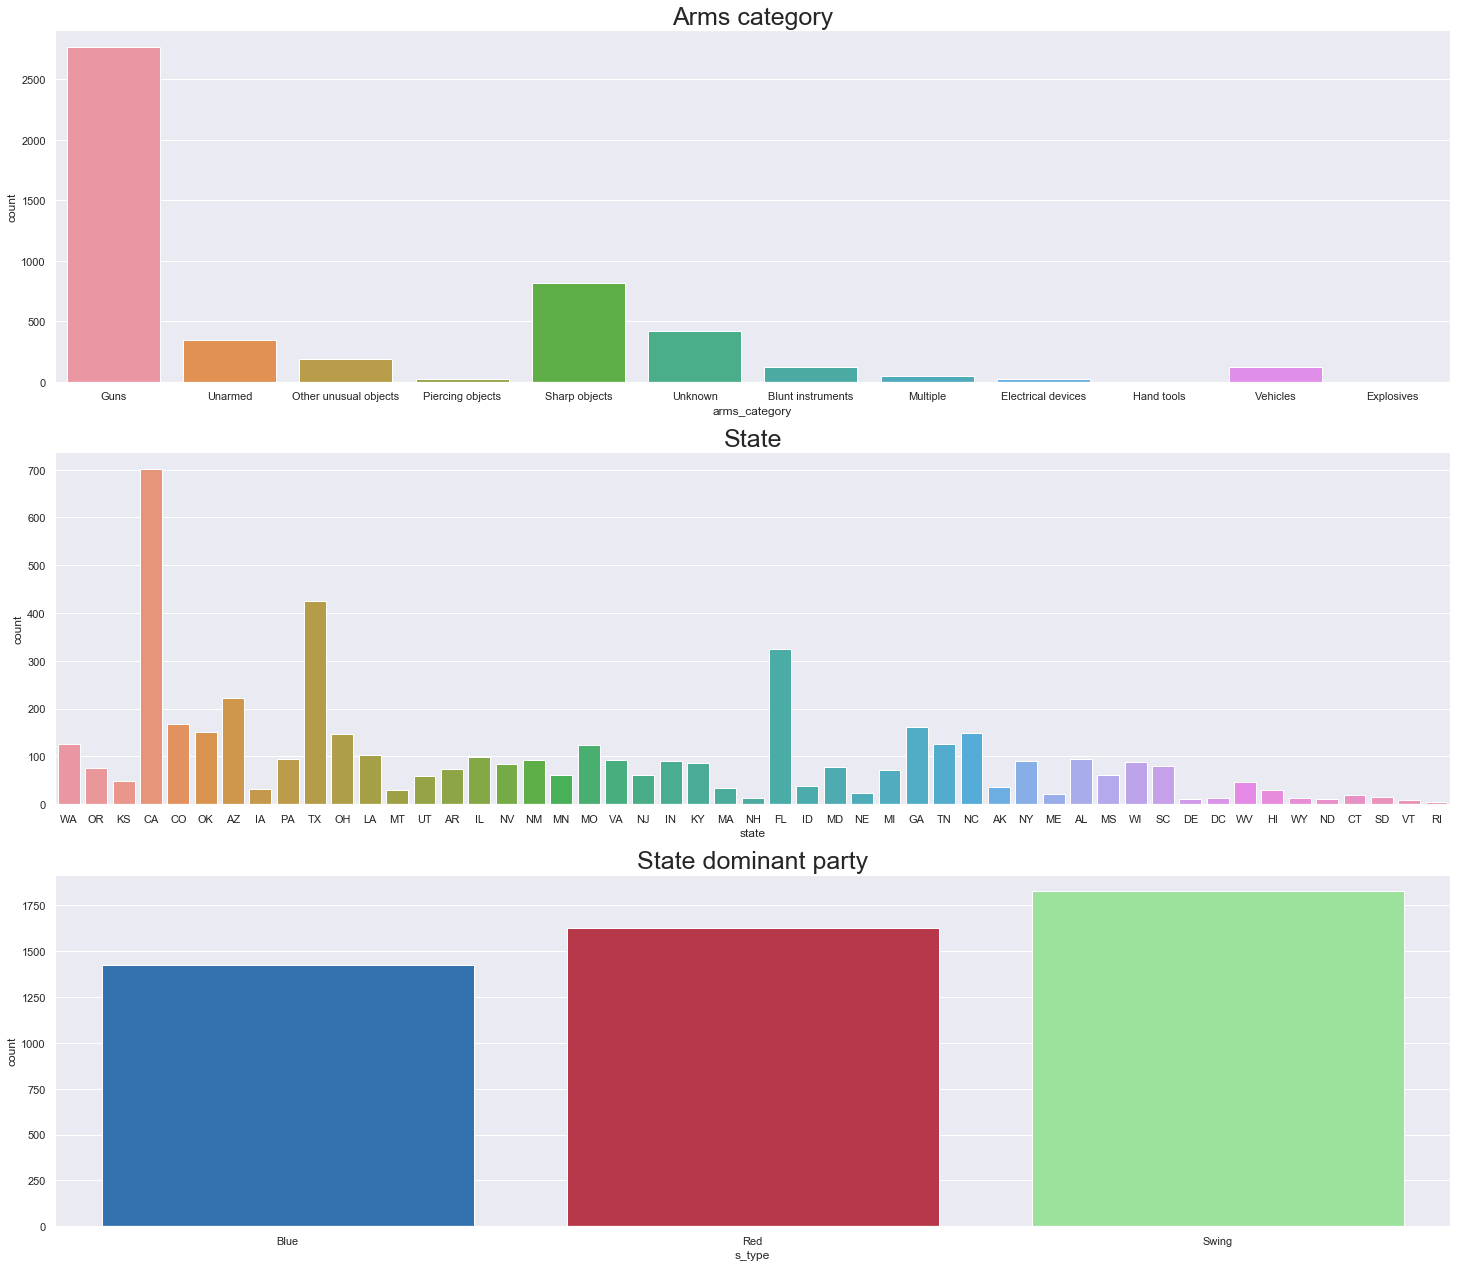

In [13]:
plt.figure(figsize=(25,22))
plt.subplot(3,1,1)
sns.countplot(x='arms_category', data=df)
plt.title('Arms category', fontsize=25)

plt.subplot(3,1,2)
sns.countplot(x='state', data=df)
plt.title('State', fontsize=25)

plt.subplot(3,1,3)
sns.countplot(x='s_type', data=df, palette=['#1f71c4', '#cc2338', 'lightgreen'])
plt.title('State dominant party', fontsize=25)

### Another very important detail is the weapon possessed by the killed suspects. Most of them had firearms with them. The second most popular weapon is sharp objects. At the same time, you can pay attention to the fact that 348 people were not armed at all, and 171 people were armed with toy weapons (this is included in the category of other unusual objects)

### Also where are states with the most cases of police shooting. It's California, Texas and Florida. So the reason os that that's are the most populated states.

### State's party dominance is distributet quite balanced. However, most of the cases took place in the Republican or Swing state

### We decided to rearrange one of the variables. Arms category contains too many different categories. We aggregated them by their broader concept: Guns, cold weapon, unarmed, other. This categories have enough observations and we be more effective for model

Text(0.5, 1.0, 'Arms category v.2')

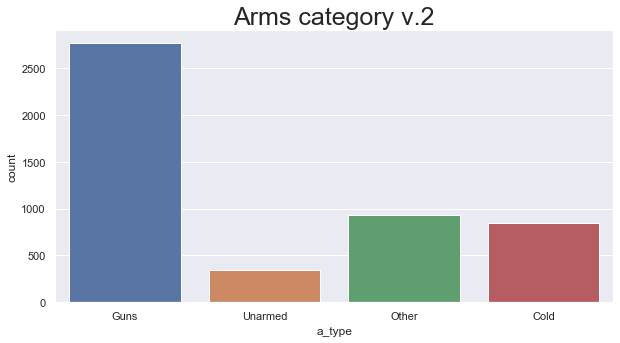

In [14]:
plt.figure(figsize=(10,5))
sns.countplot(x='a_type', data=df)
plt.title('Arms category v.2', fontsize=25)

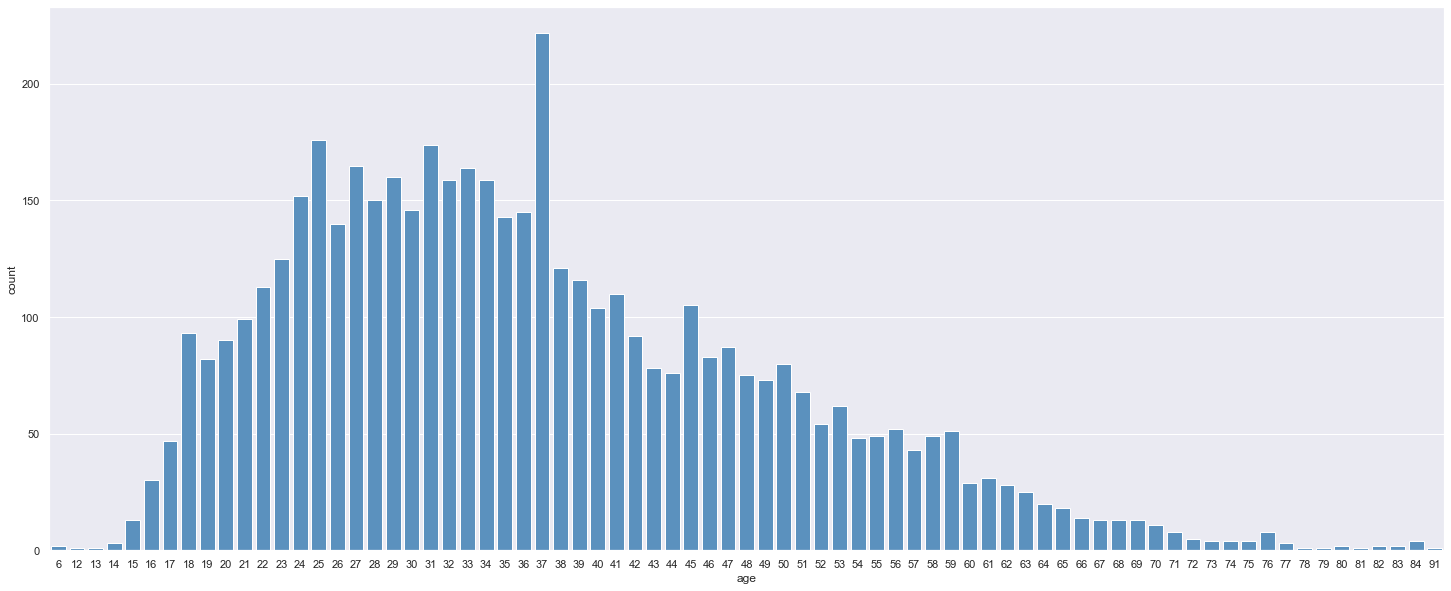

In [15]:
plt.figure(figsize=(25,10))
sns.countplot(x='age', data=df, color='#4a93cf')

#### The age distribution does not look like normal, however it should be checked by appropriate tests.

In [16]:
spst.normaltest(df['age'], axis=0, nan_policy='propagate')

NormaltestResult(statistic=346.5169363006812, pvalue=5.685953966205574e-76)

#### Test demonstrted that the distribution of age is not normal

### Is there any relation between the fact that the suspect purposefully attacks a policeman and any other signs of him? As an example, let's take a race, and see the distribution of races between the meaning of "attacks" and "does not attack"

In [17]:
race_attack = pd.crosstab(df['threat_level'], df['race'])
race_attack

race,Asian,Black,Hispanic,Native,Other,White
threat_level,,,,,,
0,42,425,381,34,17,836
1,51,873,521,44,31,1640


### The dependency, if there is one, is not obvious. We can check its presence or absence using the Chi-square test

In [18]:
chi2, p, dof, expected = spst.chi2_contingency(race_attack) 
if p<0.05: print(p, '\n', 'So we reject null hypothesis and there is which means that there is an association between threat level and race')
else: print(p, 'So we accept null hypothesis and there is which means that there is no association between threat level and race')

7.4721950552183445e-06 
 So we reject null hypothesis and there is which means that there is an association between threat level and race


### Chi-square test shows us, that there is relation between this two categorical variables. 

In [19]:
expected_df = pd.DataFrame(data=expected,
                   columns=['Asian', 'Black', 'Hispanic', 'Native', 'Other', 'White'])
chi_residuals = expected_df - race_attack

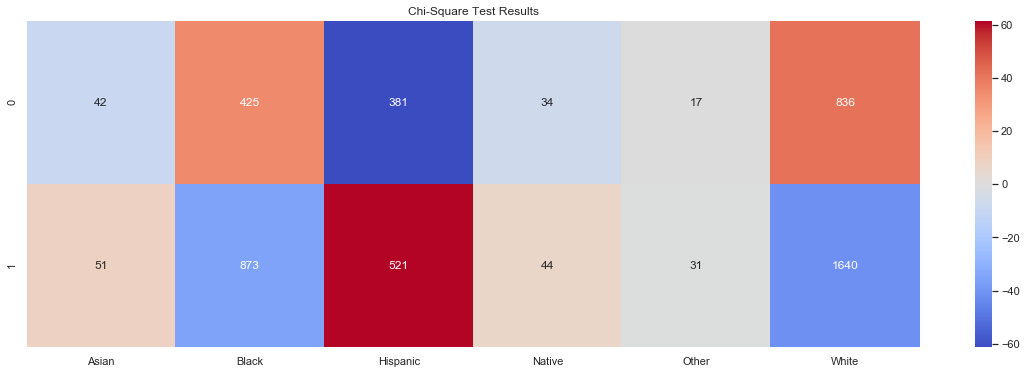

In [20]:
fig = plt.figure(figsize=(20,6))
sns.heatmap(chi_residuals, annot=race_attack, cmap='coolwarm', fmt='.4g')
plt.title('Chi-Square Test Results')
plt.show()

### This graph is a visualization of the Chi-square test. It shows great Chi-residues in the case of white, black and hispanic people. That is, their number among attackers or non-attackers differs significantly from the expected one, in which the threat level does not depend on race

### Окей, пояснение про хи квадрат. Этот тест посмотрел, есть ли разница между нашим датасетом, и "идеальным" датасетом, где для всех рас пропорции одинаковые. И вот где испанцы получились красные, а черные и белые оранжевые, значит там эта диспропорция очень ощутимая. То есть именно тот факт, что ты латинос, черный или белый сильнее влияет на то, атакуешь ты или нет

# Part 3
# Research question

## The selected dataset contains factors which created a situation when the suspected person was shot by a police officer. Within the framework of legislation, where a person can be shot by a police officer under certain circumstances (created by a suspect), it is necessary to find out what specific factors (a group of factors) create a precedent for the use of weapons by a police officer and how fair these cases were. 

## To do this, we will select the fact of an attack by the suspect as a dependent variable, since this action gives the police officer the full right to use weapons, and let's see what can influence it. In addition, in the course of the study, we will find out whether any prejudices against certain areas, groups of people are confirmed.

## Basic model

### To begin with, we want to estimate coefficient for the basic model where we trying to find relations between fact of attacking and race (also we can use variable age as an addition)

In [21]:
model = smfLGT('threat_level ~ age + C(race, Treatment(reference="White"))', data=df) 
model.fit().summary()

Optimization terminated successfully.
         Current function value: 0.646279
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           threat_level   No. Observations:                 4895
Model:                          Logit   Df Residuals:                     4888
Method:                           MLE   Df Model:                            6
Date:                Mon, 18 Oct 2021   Pseudo R-squ.:                0.005960
Time:                        10:50:40   Log-Likelihood:                -3163.5
converged:                       True   LL-Null:                       -3182.5
Covariance Type:            nonrobust   LLR p-value:                 1.158e-06
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             0.4137      0.107      3.866      0.000       0.204       0.623
C(race, Treatment(reference="White"))[T.Asian]       -0.4587      0.213     -2.154      0.031      -0.876      -0.041
C(race, Treatment(reference="White"))[T.Black]        0.0939      0.075      1.251      0.211      -0.053       0.241
C(race, Treatment(reference="White"))[T.Hispanic]    -0.3209      0.081     -3.957      0.000      -0.480      -0.162
C(race, Treatment(reference="White"))[T.Native]      -0.3635      0.233     -1.559      0.119      -0.820       0.094
C(race, Treatment(reference="White"))[T.Other]       -0.0288      0.305     -0.094      0.925      -0.627       0.570
age                                                   0.0065      0.002      2.636      0.008       0.002       0.011
=====================================================================================================================
"""

In [22]:
model = smfLGT('threat_level ~ age + C(race, Treatment(reference="White")) + a_type', data=df)
model.fit().summary()

Optimization terminated successfully.
         Current function value: 0.577630
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           threat_level   No. Observations:                 4895
Model:                          Logit   Df Residuals:                     4885
Method:                           MLE   Df Model:                            9
Date:                Mon, 18 Oct 2021   Pseudo R-squ.:                  0.1115
Time:                        10:50:40   Log-Likelihood:                -2827.5
converged:                       True   LL-Null:                       -3182.5
Covariance Type:            nonrobust   LLR p-value:                4.865e-147
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                            -0.4805      0.134     -3.597      0.000      -0.742      -0.219
C(race, Treatment(reference="White"))[T.Asian]       -0.1413      0.230     -0.615      0.538      -0.592       0.309
C(race, Treatment(reference="White"))[T.Black]        0.0705      0.081      0.876      0.381      -0.087       0.228
C(race, Treatment(reference="White"))[T.Hispanic]    -0.2392      0.087     -2.736      0.006      -0.410      -0.068
C(race, Treatment(reference="White"))[T.Native]      -0.3293      0.253     -1.301      0.193      -0.825       0.167
C(race, Treatment(reference="White"))[T.Other]        0.3129      0.327      0.956      0.339      -0.328       0.954
a_type[T.Guns]                                        1.8009      0.085     21.076      0.000       1.633       1.968
a_type[T.Other]                                       0.5288      0.097      5.467      0.000       0.339       0.718
a_type[T.Unarmed]                                    -0.0542      0.132     -0.410      0.682      -0.313       0.205
age                                                   0.0022      0.003      0.832      0.406      -0.003       0.008
=====================================================================================================================
"""

In [23]:
model = smfLGT('threat_level ~ age + C(race, Treatment(reference="White")) + s_type + signs_of_mental_illness', data=df)
model.fit().summary()

Optimization terminated successfully.
         Current function value: 0.642932
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           threat_level   No. Observations:                 4881
Model:                          Logit   Df Residuals:                     4871
Method:                           MLE   Df Model:                            9
Date:                Mon, 18 Oct 2021   Pseudo R-squ.:                 0.01166
Time:                        10:50:40   Log-Likelihood:                -3138.2
converged:                       True   LL-Null:                       -3175.2
Covariance Type:            nonrobust   LLR p-value:                 2.440e-12
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             0.2438      0.120      2.035      0.042       0.009       0.479
C(race, Treatment(reference="White"))[T.Asian]       -0.3824      0.216     -1.769      0.077      -0.806       0.041
C(race, Treatment(reference="White"))[T.Black]        0.0840      0.076      1.102      0.270      -0.065       0.234
C(race, Treatment(reference="White"))[T.Hispanic]    -0.2780      0.083     -3.339      0.001      -0.441      -0.115
C(race, Treatment(reference="White"))[T.Native]      -0.4682      0.238     -1.970      0.049      -0.934      -0.002
C(race, Treatment(reference="White"))[T.Other]        0.0923      0.308      0.300      0.764      -0.511       0.695
s_type[T.Red]                                         0.3477      0.078      4.462      0.000       0.195       0.500
s_type[T.Swing]                                       0.2418      0.074      3.258      0.001       0.096       0.387
signs_of_mental_illness[T.True]                      -0.2485      0.072     -3.438      0.001      -0.390      -0.107
age                                                   0.0070      0.003      2.779      0.005       0.002       0.012
=====================================================================================================================
"""

In [24]:
model = smfLGT('threat_level ~ age + C(race, Treatment(reference="White")) + s_type + signs_of_mental_illness + body_camera', data=df)
model.fit().summary()

Optimization terminated successfully.
         Current function value: 0.642722
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           threat_level   No. Observations:                 4881
Model:                          Logit   Df Residuals:                     4870
Method:                           MLE   Df Model:                           10
Date:                Mon, 18 Oct 2021   Pseudo R-squ.:                 0.01198
Time:                        10:50:40   Log-Likelihood:                -3137.1
converged:                       True   LL-Null:                       -3175.2
Covariance Type:            nonrobust   LLR p-value:                 2.910e-12
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             0.2594      0.120      2.156      0.031       0.024       0.495
C(race, Treatment(reference="White"))[T.Asian]       -0.3729      0.216     -1.724      0.085      -0.797       0.051
C(race, Treatment(reference="White"))[T.Black]        0.0929      0.077      1.213      0.225      -0.057       0.243
C(race, Treatment(reference="White"))[T.Hispanic]    -0.2752      0.083     -3.305      0.001      -0.438      -0.112
C(race, Treatment(reference="White"))[T.Native]      -0.4611      0.238     -1.939      0.052      -0.927       0.005
C(race, Treatment(reference="White"))[T.Other]        0.0954      0.308      0.310      0.757      -0.508       0.699
s_type[T.Red]                                         0.3447      0.078      4.422      0.000       0.192       0.498
s_type[T.Swing]                                       0.2390      0.074      3.218      0.001       0.093       0.385
signs_of_mental_illness[T.True]                      -0.2422      0.072     -3.343      0.001      -0.384      -0.100
body_camera[T.True]                                  -0.1330      0.092     -1.438      0.150      -0.314       0.048
age                                                   0.0069      0.003      2.754      0.006       0.002       0.012
=====================================================================================================================
"""

# Sklearn methodologies
#### Let's write some useful functions: 

In [25]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def rmse(y, p):
    return np.sqrt(mean_squared_error(y, p))

#def beatiful_coef(coefs, feature_names=X_cat.columns):
 #   return pd.DataFrame(coefs, index=feature_names, columns=["coef"]).sort_values(
  #      "coef", ascending=False)

def metrics (y_valid, x):
    return print('RMSE: {}'.format(rmse(y_valid, x)),
                'ROC_AUC_score: {}'.format(roc_auc_score(y_valid, x)),
                'acuracy score: {}'.format(accuracy_score(y_valid, x)),
                'precision score: {}'.format(precision_score(y_valid, x)),
                'recall score: {}'.format(recall_score(y_valid, x)))

def metrics_tree (y_valid, x):
    return print('RMSE: {}'.format(rmse(y_valid, x)),
                'ROC_AUC_score: {}'.format(roc_auc_score(y_valid, x)))
                #'acuracy score: {}'.format(accuracy_score(y_valid, x)),
                #'precision score: {}'.format(precision_score(y_valid, x)),
                #'recall score: {}'.format(recall_score(y_valid, x)))

# Data preparation
#### Preparing of the data for a logistic model and a random forest:

#### Encoding of categorical variables:

In [26]:
label_enc = preprocessing.LabelEncoder()
y = label_enc.fit_transform(y)
y[:20]

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1])

In [27]:
cat_features_mask = (X.dtypes == "object").values
print(cat_features_mask)
print(len(cat_features_mask[cat_features_mask==True]))

[ True  True False False  True  True]
4


In [28]:
X_copy = X.copy()
for feature in X.columns[cat_features_mask]: 
    for name, count in X[feature].value_counts().items():
        X[feature].replace(name, count, inplace=True)
X.head(5)

,gender,race,signs_of_mental_illness,body_camera,a_type,s_type
0,4659,92,True,False,2754,1427
1,4659,2466,False,False,2754,1427
2,4659,902,False,False,347,1627
3,4659,2466,True,False,933,1427
4,4659,902,False,False,847,1827


In [29]:
enc = preprocessing.OneHotEncoder(sparse=False, drop='first')
X_cat = enc.fit_transform(X_copy[X_copy.columns[cat_features_mask]])
X_cat = pd.DataFrame(data=X_cat)
X_cat.head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [30]:
y = pd.DataFrame(y)

#### Let's split the data for a train and a test:

In [31]:
train_share = 0.7
train_part_len = int(train_share * df.shape[0])
X_train = X_cat.values[:train_part_len, :]
X_valid = X_cat.values[train_part_len:, :]
y_train = y.values[:train_part_len]
y_valid = y.values[train_part_len:]

## LogisticRegression:

In [32]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf_pred = clf.predict(X_valid)

/Users/daniilseremetev/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### See metrics for the LogisticRegression and for cross-validation:

In [33]:
metrics(y_valid, clf_pred)

RMSE: 0.5862103817605492 ROC_AUC_score: 0.6241256520653664 acuracy score: 0.6563573883161512 precision score: 0.7698154180238871 recall score: 0.7111334002006018


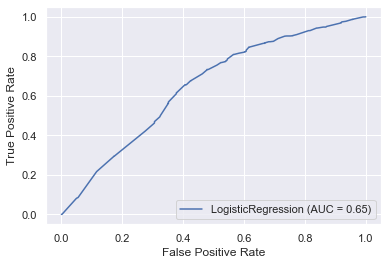

In [34]:
plot_roc_curve(clf, X_valid, y_valid) 

In [35]:
accuracy_score(y_valid, clf_pred)

0.6563573883161512

## Logistic Regression with Regularization and Cross Validation

### L1

In [36]:
clfCV_l1 = LogisticRegressionCV(random_state=0, cv=5, penalty='l1', solver='saga').fit(X_train, y_train)
clfCV_l1_pred = clfCV_l1.predict(X_valid)
metrics(y_valid, clfCV_l1_pred)

/Users/daniilseremetev/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE: 0.6035405275413406 ROC_AUC_score: 0.6238354802398463 acuracy score: 0.6357388316151202 precision score: 0.7776456599286563 recall score: 0.6559679037111334


### L2

In [37]:
clfCV_l2 = LogisticRegressionCV(random_state=0, cv=5, penalty='l2', solver='saga').fit(X_train, y_train)
clfCV_l2_pred = clfCV_l2.predict(X_valid)
metrics(y_valid, clfCV_l2_pred)

/Users/daniilseremetev/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE: 0.596092660985773 ROC_AUC_score: 0.6268138476565066 acuracy score: 0.6446735395189004 precision score: 0.7771362586605081 recall score: 0.675025075225677


### Elastic Net

In [38]:
clfCV_el = LogisticRegressionCV(random_state=0, cv=5, penalty='elasticnet', solver='saga', l1_ratios=list(np.linspace(0,0.5,20))).fit(X_train, y_train)
clfCV_el_pred = clfCV_el.predict(X_valid)
print(metrics(y_valid, clfCV_el_pred))

/Users/daniilseremetev/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE: 0.6035405275413406 ROC_AUC_score: 0.6238354802398463 acuracy score: 0.6357388316151202 precision score: 0.7776456599286563 recall score: 0.6559679037111334
None


# Random Forest Regressor

In [39]:
from sklearn.ensemble import RandomForestRegressor

In [40]:
#forest = RandomForestRegressor(n_estimators=10, random_state=17 )

In [41]:
#forest.fit(X_train, y_train);
#forest_valid_pred = forest.predict(X_valid)
#metrics_tree(y_valid, forest_valid_pred)

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
forest_c = RandomForestClassifier(n_estimators=10, random_state=17 )
forest_c.fit(X_train, y_train);
forest_c_valid_pred = forest_c.predict(X_valid)
metrics(y_valid, forest_c_valid_pred)

RMSE: 0.5902995919424497 ROC_AUC_score: 0.6034993627169719 acuracy score: 0.6515463917525773 precision score: 0.7520576131687243 recall score: 0.7331995987963892


/Users/daniilseremetev/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


#### The quality become better a litle, but we should choose hyperparameters:

#### GridSearchCV will find optimal ones:

In [44]:
from sklearn.metrics import make_scorer

In [45]:
tree_params = {'max_depth':np.arange(1, 10),
              'n_estimators': np.arange(4, 15),
              'min_samples_leaf': [2,3,4],
              'min_samples_split': [1,2,3,4]}
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'Precission': make_scorer(precision_score), 'Recall': make_scorer(recall_score)}

In [46]:
f_grid = GridSearchCV(RandomForestClassifier(), tree_params,
                      scoring=scoring, cv=5, n_jobs=-1, refit='AUC')

In [47]:
f_grid.fit(X_train, y_train)

/Users/daniilseremetev/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,...
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples

In [48]:
f_grid_pred = f_grid.predict(X_valid)

In [49]:
metrics(y_valid, forest_c_valid_pred)

RMSE: 0.5902995919424497 ROC_AUC_score: 0.6034993627169719 acuracy score: 0.6515463917525773 precision score: 0.7520576131687243 recall score: 0.7331995987963892


In [50]:
metrics(y_valid, f_grid_pred)

RMSE: 0.5920434645509786 ROC_AUC_score: 0.6244223938190117 acuracy score: 0.6494845360824743 precision score: 0.7726763717805151 recall score: 0.6920762286860582


#### For now, we achive 0.62 of ROC_AUC_score and 0.6 for RMSE.  
  
  #### The next plan:  
1. Try to echance the model   
2. Make deneralized results

# Adaboosting

In [51]:
# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
# Import AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

In [52]:
# Instantiate dt
dt = DecisionTreeClassifier(max_depth=2, random_state=1)
# Instantiate ada
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=180, random_state=1)

In [54]:
# Fit ada to the training set
ada.fit(X_train, y_train)

# Compute the probabilities of obtaining the positive class
y_pred_proba_ada = ada.predict(X_valid)

/Users/daniilseremetev/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [56]:
# Evaluate test-set roc_auc_score
metrics(y_valid, y_pred_proba_ada)

RMSE: 0.5773502691896257 ROC_AUC_score: 0.6263364328794243 acuracy score: 0.6666666666666666 precision score: 0.7683438155136268 recall score: 0.7352056168505516


In [111]:
y_pred_proba_ada

array([0.50199739, 0.50199739, 0.50193178, ..., 0.49775894, 0.50231344,
       0.50231344])

In [ ]:
plot_roc_curve(ada, X_valid, y_valid) 

# Gradient Boosting

In [112]:
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate gb
gb = GradientBoostingRegressor(max_depth=4,
                               n_estimators=200,
                               random_state=2)

In [113]:
# Fit gb to the training set
gb.fit(X_train, y_train)

# Predict test set labels
y_pred_gb = gb.predict(X_valid)

/Users/daniilseremetev/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [116]:
# Compute MSE
mse_test = mean_squared_error(y_valid, y_pred_gb)
mse_test
metrics_tree(y_valid, y_pred_gb)

RMSE: 0.46360547481121434 ROC_AUC_score: 0.6408132695028316


In [115]:
y_pred_gb

array([ 0.81566852,  0.81566852,  0.79440546, ..., -0.00883308,
        0.84752684,  0.84752684])

### Линейная классификация

In [126]:
from sklearn.svm import SVC

In [128]:
svc = SVC(kernel='linear', C=1.0, random_state=1)

svc.fit(X_train, y_train)
svc_pred = svc.predict(X_valid)
metrics(y_valid, svc_pred)

RMSE: 0.6035405275413406 ROC_AUC_score: 0.6238354802398463 acuracy score: 0.6357388316151202 precision score: 0.7776456599286563 recall score: 0.6559679037111334


/Users/daniilseremetev/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [129]:
svc_pred

array([1, 1, 1, ..., 0, 1, 1])

### Нелинейная классификация

In [132]:
svm_rbf = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm_rbf.fit(X_train, y_train)

svm_rbf_pred = svm_rbf.predict(X_valid)
metrics(y_valid, svm_rbf_pred)

/Users/daniilseremetev/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE: 0.5983941856122689 ROC_AUC_score: 0.626578425232028 acuracy score: 0.6419243986254296 precision score: 0.7780373831775701 recall score: 0.6680040120361084


In [135]:
from sklearn.neighbors import KNeighborsClassifier

In [147]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_valid)
metrics(y_valid, knn_pred)

RMSE: 0.5755618799601223 ROC_AUC_score: 0.5971506221721934 acuracy score: 0.6687285223367697 precision score: 0.7426955702167767 recall score: 0.7903711133400201


/Users/daniilseremetev/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


In [142]:
knn_params = {'n_neighbors': np.arange(1,16),
              'weights': ['uniform', 'distance'],
             'p': [1, 2]}

In [143]:
knn_grid = GridSearchCV(KNeighborsClassifier(),knn_params, scoring=scoring, cv=5, n_jobs=-1, refit='AUC')

In [144]:
knn_grid.fit(X_train, y_train)

/Users/daniilseremetev/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit='AUC', return_train_score=False,
             scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),
                      'Precission': make_scorer(precision_score),
                      'Recall': make_scorer(recall_score)},
             verbose=0)

In [146]:
knn_grid_pred = knn_grid.predict(X_valid)
metrics(y_valid, knn_grid_pred)

RMSE: 0.5707654473391751 ROC_AUC_score: 0.6023430553669742 acuracy score: 0.6742268041237114 precision score: 0.7455399061032864 recall score: 0.7963891675025075
